### Import Libraries and Connect to Server

In [35]:
import swat
import dlpy
from dlpy.splitting import two_way_split
from dlpy.applications import *
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
# Create CAS Connection
conn = swat.CAS(host, portnum, protocol='http')

### Load data and view Summary Statistics

In [19]:
# Load the Fruit Image Data
retail_training_images = dlpy.ImageTable.load_files(conn, path='/data/retail')

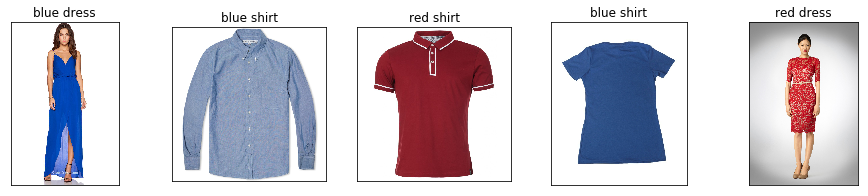

In [20]:
# Preview the Fruit Images
retail_training_images.show(nimages=5, ncol=5, randomize=True)

In [21]:
# View the Fruit Class Frequency
retail_training_images.label_freq

,Level,Frequency
black jeans,1,344
blue dress,2,386
blue jeans,3,356
blue shirt,4,369
red dress,5,380
red shirt,6,332


In [22]:
# View Image Summary
retail_training_images.image_summary

jpg                  2167
minWidth              313
maxWidth             5280
minHeight             277
maxHeight            7360
meanWidth         1075.22
meanHeight        1342.09
mean1stChannel    174.989
min1stChannel           0
max1stChannel         255
mean2ndChannel    166.346
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    182.342
min3rdChannel           0
max3rdChannel         255
dtype: object

### Data Preparation

In [23]:
# Resize Images to 224x224
retail_training_images.resize(width=224, height=224, inplace=True)

In [24]:
# Shuffle Images
retail_training_images.shuffle(casout=dict(name='fruit_training_images', replace=True));

In [25]:
# Split Data into Train / Test
train, test = two_way_split(retail_training_images, test_rate=20, seed=12345)

### Build Deep Learning Models

In [26]:
# Simple Convolutional Neural Network (CNN)
retail_simple_model = Sequential(conn, model_table='simple_cnn')

retail_simple_model.add(InputLayer(3,224,224, offsets=train.channel_means))

retail_simple_model.add(Conv2d(n_filters=8, width=7, height=7, stride=1, act='relu'))

retail_simple_model.add(Pooling(width=2, height=2, stride=2))

retail_simple_model.add(Conv2d(n_filters=8, width=7, height=7, stride=1, act='relu'))

retail_simple_model.add(Pooling(width=2, height=2))

retail_simple_model.add(Dense(n=16, act='relu'))

retail_simple_model.add(OutputLayer(act='softmax', n=6))

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Fully-connected layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


In [27]:
# Preview Model Architecture
retail_simple_model.print_summary()

,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters
0,Input1,input,None,None,None,"(224, 224, 3)","(0, 0)"
1,Convo.1,convo,"(7, 7)",1,Relu,"(224, 224, 8)","(1176, 8)"
2,Pool1,pool,"(2, 2)",2,Max,"(112, 112, 8)","(0, 0)"
3,Convo.2,convo,"(7, 7)",1,Relu,"(112, 112, 8)","(3136, 8)"
4,Pool2,pool,"(2, 2)",2,Max,"(56, 56, 8)","(0, 0)"
5,F.C.1,fc,"(25088, 16)",None,Relu,16,"(401408, 0)"
6,Output1,output,"(16, 6)",None,Softmax,6,"(96, 6)"
7,,,,,,,405838


In [28]:
# Fit ResNet Deep Learning Model on GPU
retail_simple_model.fit(
                    data=train,
                    mini_batch_size=32,
                    max_epochs=10,
                    lr=0.001,
                    gpu=dict(devices=[1]),
                    n_threads=1,
                    log_level=2);

NOTE: Either dataspecs or inputs need to be non-None, therefore inputs=_image_ is used
NOTE: Training from scratch.
NOTE: dlgrd007.unx.sas.com: 1 out of 2 available GPU devices are used.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 405854.
NOTE:  The approximate memory cost is 128.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       1.03 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The total mini-batch size per thread on each worker is 32.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 32.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      6
NOTE:  Levels for the target variable:
NOTE:  Level      0: black jeans
NOTE:  Level      1: blue dress 
NOTE:  Level      2: blue jeans 
NOTE:  Level      3: blue shirt 
NOTE:  Level      4: red dress  
NOTE:  Level      5: red shirt  
NOTE:  Number of input variables:     1
NOTE: 

In [29]:
# View Training History
retail_simple_model.training_history

,Epoch,LearningRate,Loss,FitError
0,1,0.001,2.822951,0.814879
1,2,0.001,1.783227,0.814879
2,3,0.001,1.775834,0.816609
3,4,0.001,1.766181,0.807958
4,5,0.001,1.755324,0.810842
5,6,0.001,1.740907,0.801038
6,7,0.001,1.724861,0.788927
7,8,0.001,1.709087,0.769896
8,9,0.001,1.691641,0.756632
9,10,0.001,1.672240,0.735294


In [30]:
# Try Common Pre-Built ResNet 50 Model
retail_resnet_model = ResNet50_Caffe(
                        conn,
                        model_table='resnet50',
                        n_classes=6,
                        n_channels=3,
                        width=224,
                        height=224,
                        scale=1,
                        offsets=train.channel_means,
                        pre_trained_weights=True, 
                        pre_trained_weights_file='/data/retail/ResNet-50-model.caffemodel.h5',
                        include_top=False)

NOTE: Model weights attached successfully!
NOTE: Model table is attached successfully!
NOTE: Model is named to "resnet50" according to the model name in the table.


In [31]:
# Fit ResNet Deep Learning Model on GPU
retail_resnet_model.fit(
                    data=train,
                    mini_batch_size=32,
                    max_epochs=10,
                    lr=0.001,
                    gpu=dict(devices=[1]),
                    n_threads=1,
                    log_level=2);

NOTE: Either dataspecs or inputs need to be non-None, therefore inputs=_image_ is used
NOTE: Training based on existing weights.
NOTE: dlgrd007.unx.sas.com: 1 out of 2 available GPU devices are used.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 23520390.
NOTE:  The approximate memory cost is 347.00 MB.
NOTE:  Loading weights cost       0.83 (s).
NOTE:  Initializing each layer cost       1.14 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The total mini-batch size per thread on each worker is 32.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 32.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      6
NOTE:  Levels for the target variable:
NOTE:  Level      0: black jeans
NOTE:  Level      1: blue dress 
NOTE:  Level      2: blue jeans 
NOTE:  Level      3: blue shirt 
NOTE:  Level      4: red dress  
NOTE:  Level      5: red shirt  
NOTE:  Number of input variable

In [32]:
# View Training History
retail_resnet_model.training_history

,Epoch,LearningRate,Loss,FitError
0,1,0.001,1.414478,0.504037
1,2,0.001,0.734470,0.134948
2,3,0.001,0.459719,0.066321
3,4,0.001,0.325635,0.043829
4,5,0.001,0.248173,0.028258
5,6,0.001,0.197955,0.020761
6,7,0.001,0.162868,0.015571
7,8,0.001,0.137070,0.010957
8,9,0.001,0.117325,0.008074
9,10,0.001,0.101814,0.006344


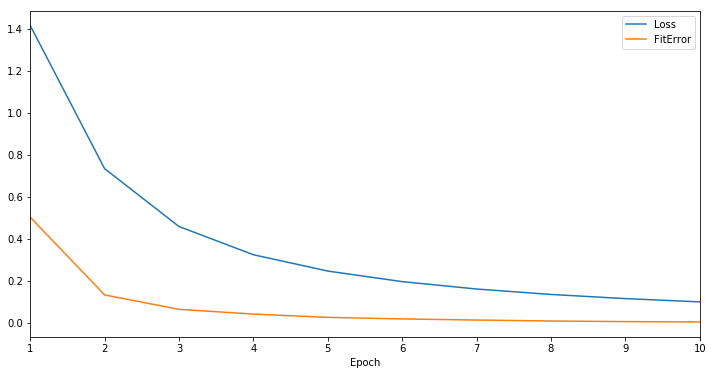

In [41]:
# Plot the Training and Validation Error
retail_resnet_model.plot_training_history(fig_size=(12,6), items=('Loss','FitError'))

### Test Error and View Predictions

In [42]:
# Score Test Data Using Simple Model
retail_simple_model.predict(test, gpu=dict(devices=[1]))

NOTE: Due to data distribution, miniBatchSize has been limited to 8.
NOTE: dlgrd007.unx.sas.com: 1 out of 2 available GPU devices are used.


[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(anviol)  Valid_Res_qlgHB5   433       13   
 
                                             casTable  
 0  CASTable('Valid_Res_qlgHB5', caslib='CASUSER(a...  

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read           433
 1  Number of Observations Used           433
 2  Misclassification Error (%)      78.06005
 3                   Loss Error      1.864754

+ Elapsed: 2.2s, user: 1.51s, sys: 1.34s, mem: 1.8e+03mb

In [43]:
# Score Test Data Using Common Pre-built ResNet Model
retail_resnet_model.predict(test, gpu=dict(devices=[1]))

NOTE: Due to data distribution, miniBatchSize has been limited to 8.
NOTE: dlgrd007.unx.sas.com: 1 out of 2 available GPU devices are used.


[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(anviol)  Valid_Res_QAfIez   433       13   
 
                                             casTable  
 0  CASTable('Valid_Res_QAfIez', caslib='CASUSER(a...  

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read           433
 1  Number of Observations Used           433
 2  Misclassification Error (%)      2.771363
 3                   Loss Error      0.137243

+ Elapsed: 3.67s, user: 3.04s, sys: 1.32s, mem: 774mb

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(anviol).


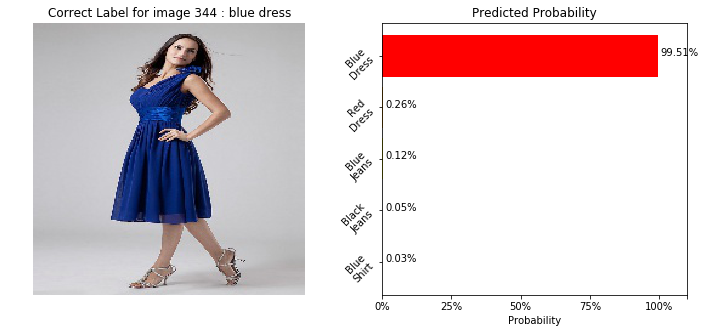

In [47]:
# Plot Predictions (Correct Classification)
retail_resnet_model.plot_evaluate_res(img_type='C', randomize=True, n_images=1)

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(anviol).


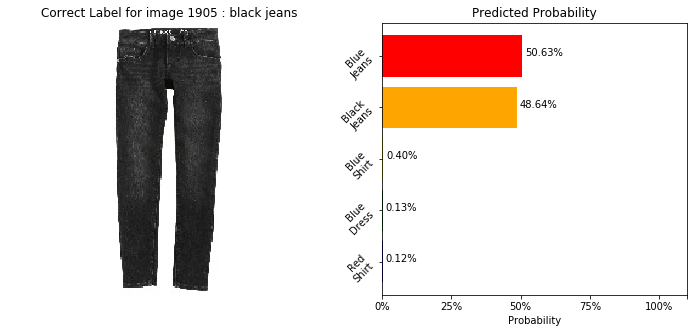

In [48]:
# Plot Predictions (Misclassification)
retail_resnet_model.plot_evaluate_res(img_type='M', randomize=True, n_images=1)